<center><h1>A Comprehensive Analysis of Convolutional Neural Networks</h1>
<h2>Matthias Bartolo</h2>

</center>

# Convolutional Neural Network (CNN)

This assignment is an _edited_ version of Tensorflow's official [CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn). The goal of this assignment is to go through the notebook and fill in the empty code cells when prompted. Moreover, you will be asked to write down short comments on any notable observations in the _Comments_ section under each question.

As a precursor to starting this assignment, you can optionally go through the original notebook and read through any extra comments that might have been removed in this version.

This notebook can be run locally, or can be run from <b>Google Colab</b> which can be found [here](https://colab.research.google.com/drive/1PztXT1Xe7AMkNpy-O4tUAkn2wDfeI41H?usp=sharing).

### Import TensorFlow

<font size="0.7">

```python
conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# Anything above 2.10 is not supported on the GPU on Windows Native
python -m pip install "tensorflow<2.11"
# Verify the installation:
python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
```

</font>

In [17]:
from time import time
import tensorflow as tf
import numpy as np
import seaborn as sns
import cv2

import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

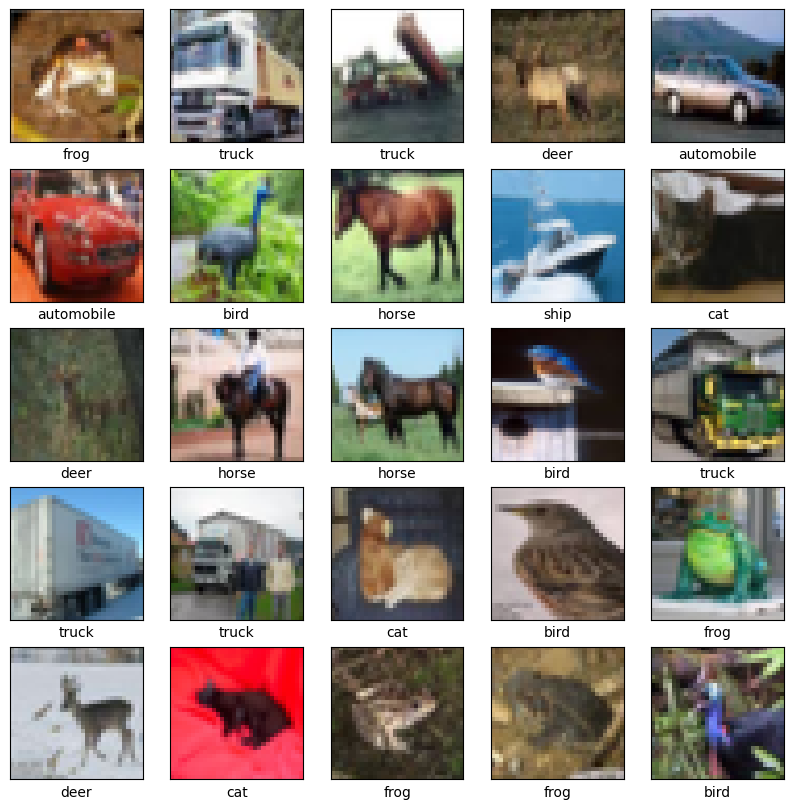

In [18]:
# Loading and splitting the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalizing pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Declaring the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plotting the first 25 images from the training set and displaying the class name below each image
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Creating the model's architecture

In [19]:
def fit(model, epochs:int=100, optimizer=Adam(clipnorm=1.0), verbose:int=1, batch_size:int=256, callbacks=EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), colors:tuple=('blue','purple','green','cyan'), do_display:bool=False, do_save:bool=False, save_name:str='model'):
    """Function which fits a model to the training data and plots the training process.

    Args:
        model (keras.model): Model to fit
        epochs (int, optional): Number of epochs to train for. Defaults to 10.
        optimizer (str, optional): Optimizer to use. Defaults to 'adam'.
        verbose (int, optional): Verbosity of training. Defaults to 1.
        batch_size (int, optional): Batch size. Defaults to 32.
        callbacks (list, optional): List of callbacks. Defaults to [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)].
        colors (tuple, optional): Colors to use for plotting. Defaults to ('blue','purple','green','cyan').`
        do_save (bool, optional): Whether to save the model. Defaults to False.
        save_name (str, optional): Name of the model to save. Defaults to 'model'.
    """

    # Loading the model
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    # Printing the model summary
    print(model.summary())

    # Setting the start time
    s=time()

    # Training Model
    history = model.fit(train_images, train_labels, epochs=epochs, verbose=verbose,
                        validation_data=(test_images, test_labels), batch_size=batch_size, callbacks=callbacks)

    # Printing the training time
    print(f'\033[36mTraining Time: {round(time()-s,2)}s\033[0m')
    print('*'*50)

    # Plotting Training process
    plt.plot(history.history['accuracy'], label='Train Accuracy', color = colors[0])
    plt.plot(history.history['loss'], label = 'Train Loss', color = colors[1], linestyle='dashed')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', color = colors[2])
    plt.plot(history.history['val_loss'], label = 'Validation Loss', color = colors[3], linestyle='dashed')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Testing the model
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

    # Calculating the Precision, Recall and F1 Score
    y_pred = model.predict(test_images)
    y_pred = [np.argmax(i) for i in y_pred]
    
    # Printing the test results
    print(f'\033[35mTest Accuracy: {round(test_acc,2)}\033[0m')
    print(f'\033[34mTest Loss: {round(test_loss,2)}\033[0m')
    print(f'\033[33mTest Precision: {round(precision_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[32mTest Recall: {round(recall_score(test_labels, y_pred, average="weighted"),2)}\033[0m')
    print(f'\033[31mTest F1 Score: {round(f1_score(test_labels, y_pred, average="weighted"),2)}\033[0m')

    # Plotting the confusion matrix
    if do_display:
        cm = confusion_matrix(test_labels, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    # Saving the model
    if do_save:
        model.save(f'{save_name}.h5')

    return test_acc

In the original notebook, the below model configuration was used. 3 Convolution Layers were used to extract visual features from the image. Then these features are passed to a normal Neural Network which will learn to classify the different class labels.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

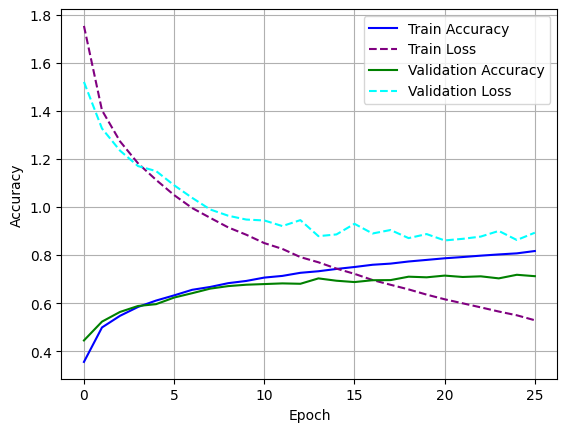

313/313 - 0s - loss: 0.8608 - accuracy: 0.7145 - 369ms/epoch - 1ms/step
313/313 [==============================] - 0s 728us/step
Test Accuracy: 0.71
Test Loss: 0.86
Test Precision: 0.72
Test Recall: 0.71
Test F1 Score: 0.71


In [4]:
# Creating the model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0)
del model

### Q.7
The original CNN architecture managed to achieve ~70% accuracy on the test set using 122,570 model parameters. Can you define your own CNN architecture and try to improve on the original model? Improvements include: achieving higher performance on the test set, comparable performance using significantly fewer model parameters, faster training time, different model architecture, etc...

Note down which factors of your CNN architecture you found to be the most responsible for contributing to model performance.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                      

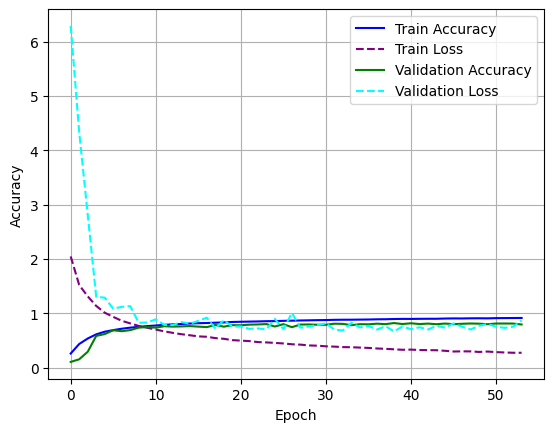

313/313 - 1s - loss: 0.6691 - accuracy: 0.8214 - 580ms/epoch - 2ms/step
313/313 [==============================] - 1s 1ms/step
Test Accuracy: 0.82
Test Loss: 0.67
Test Precision: 0.82
Test Recall: 0.82
Test F1 Score: 0.82


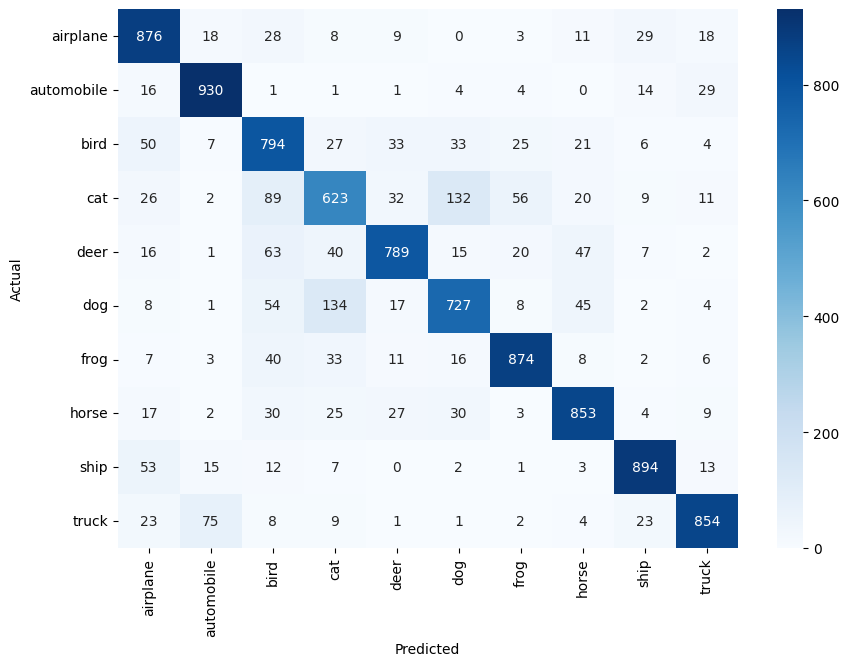

In [5]:
# Defining Custom CNN Model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Conv2D(32, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Adding Dropout for regularization

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Adding Dropout for regularization

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
model.add(layers.Conv2D(128, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Conv2D(128, (3, 3), activation='elu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.25)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Adding Dense/Fully-Connected Layers.
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization()) # Adding BatchNormalization for regularization
model.add(layers.Dropout(0.5)) # Adding Dropout for regularization

# Final Dense Layer (Output Layer having 10 neurons for 10 classes)
model.add(layers.Dense(10))

# Adding Softmax Activation to the output layer
model.add(layers.Activation('softmax'))

# Fitting the model
fit(model,verbose=0, epochs=1000, optimizer=Adam(clipnorm=3.0, learning_rate=0.007), batch_size=512, callbacks=EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), colors=('blue','purple','green','cyan'), do_display=True, do_save=True, save_name='model')
del model

In [40]:
import SaRa.saraRC1 as sara

class SaRaAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, grid_size, generator='itti'):
        super(SaRaAttentionLayer, self).__init__()
        self.grid_size = grid_size
        self.generator = generator

    def build(self, input_shape):
        super(SaRaAttentionLayer, self).build(input_shape)

    def call(self, inputs):
        saliency_scores = self.calculate_saliency_scores(inputs)
        
        # Normalize saliency scores to get attention weights
        attention_scores = tf.nn.softmax(saliency_scores)

        # Weighted sum of inputs based on attention scores
        weighted_input = inputs * tf.expand_dims(attention_scores, axis=-1)
        saliency_map = tf.reduce_sum(weighted_input, axis=-1)

        return saliency_map

    def calculate_saliency_scores(self, images):
        all_saliency_scores = []
        for img in images:
            # Changing tensor to numpy array
            numpy_array = img.numpy()

            # Convert the NumPy array to an OpenCV image
            bgr_img = cv2.cvtColor(np.uint8(numpy_array * 255), cv2.COLOR_RGB2BGR)
            # bgr_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            sara.reset()
            sara_info = sara.return_sara(bgr_img, self.grid_size, self.generator)

            sara_dict = {}
            for info in sara_info[1]:
                rank, index, score, entropy, entropy_sum, centre_bias, depth, quartile = info
                sara_dict[rank] = {}
                sara_dict[rank]['score'] = score
                sara_dict[rank]['entropy'] = entropy
                sara_dict[rank]['entropy_sum'] = entropy_sum
                sara_dict[rank]['centre_bias'] = centre_bias
                sara_dict[rank]['depth'] = depth
                sara_dict[rank]['index'] = index
                sara_dict[rank]['quartile'] = quartile

            # Sorting the dictionary by the scores key in the nested dictionary
            sorted_sara_dict = {}
            for key in sorted(sara_dict, key=lambda k: sara_dict[k]['score'], reverse=True):
                sorted_sara_dict[key] = sara_dict[key]

            saliency_scores = np.array([info['score'] for info in sorted_sara_dict.values()])
            all_saliency_scores.append(saliency_scores)

        return np.array(all_saliency_scores)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'grid_size': self.grid_size,
            'generator': self.generator,
        })
        return config


In [62]:
import tensorflow as tf

class ConvertToNumpy(tf.keras.layers.Layer):
    def __init__(self):
        super(ConvertToNumpy, self).__init__()

    def call(self, inputs):
        if inputs.shape[0] is not None:
            # Handle dynamic shapes by converting to numpy
            print(inputs.numpy())
            return inputs.numpy()
        
        return inputs

class ConvertToTensor(tf.keras.layers.Layer):
    def __init__(self):
        super(ConvertToTensor, self).__init__()

    def call(self, inputs):
        # If input is a numpy array, convert to tensor
        return tf.convert_to_tensor(inputs)

    def compute_output_shape(self, input_shape):
        return input_shape



In [21]:
tf.config.run_functions_eagerly(True)

In [63]:
# Creating the model
model = models.Sequential()

# Performing 2D Convolution + MaxPooling on the image, reducing its size.
# These extract the most important visual features from the image.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(ConvertToNumpy())
model.add(ConvertToTensor())

# Adding Dense/Fully-Connected Layers.
# These contian the 'classification' part of the model.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# Fitting the model
fit(model,verbose=0, epochs=50)
del model

TypeError: Exception encountered when calling layer "convert_to_numpy_24" (type ConvertToNumpy).

in user code:

    File "C:\Users\User\AppData\Local\Temp\ipykernel_19264\2793989207.py", line 8, in call  *
        if None not in inputs.shape[0]:

    TypeError: argument of type 'NoneType' is not iterable


Call arguments received by layer "convert_to_numpy_24" (type ConvertToNumpy):
  • inputs=tf.Tensor(shape=(None, 4, 4, 64), dtype=float32)